# Лабораторная работа 2

## Полносвязная нейронная сеть

Реализовать нейронную сеть, состоящую из двух полносвязных слоев и решающую задачу классификации на наборе данных из лабораторной работы 1.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scripts.data_utils import load_CIFAR10
import itertools
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold
from scipy.stats import mode



%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

1. Добавьте реализации методов класса TwoLayerNet . Проверьте вашу реализацию на модельных данных (Код приведен ниже).  

In [20]:
import numpy as np

class TwoLayerNet(object):
    """
    Двухслойная полносвязная нейронная сеть. Сеть имеет входную размерность N,
    размер скрытого слоя H и выполняет классификацию на C классов.
    Мы обучаем сеть с использованием функции потерь softmax и L2-регуляризацией
    для матриц весов. После первого полносвязного слоя применяется нелинейность ReLU.
    Другими словами, сеть имеет следующую архитектуру:
    вход - полносвязный слой - ReLU - полносвязный слой - softmax
    Выходы второго полносвязного слоя - это оценки для каждого класса.
    """

    def __init__(self, input_size, hidden_size, output_size, std=1e-4):
        """
        Инициализация модели. Веса инициализируются малыми случайными значениями,
        а смещения инициализируются нулями. Веса и смещения хранятся в
        переменной self.params, которая является словарем со следующими ключами:

        W1: Веса первого слоя; имеет форму (D, H)
        b1: Смещения первого слоя; имеет форму (H,)
        W2: Веса второго слоя; имеет форму (H, C)
        b2: Смещения второго слоя; имеет форму (C,)

        Входы:
        - input_size: Размерность входных данных D.
        - hidden_size: Количество нейронов H в скрытом слое.
        - output_size: Количество классов C.
        """
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def loss(self, X, y=None, reg=0.0):
        """
        Вычисление функции потерь и градиентов для двухслойной полносвязной нейронной
        сети.

        Входы:
        - X: Входные данные формы (N, D). Каждый X[i] - обучающий образец.
        - y: Вектор меток обучения. y[i] - метка для X[i], каждая y[i] -
          целое число в диапазоне 0 <= y[i] < C. Этот параметр является необязательным;
          если он не передан, мы возвращаем только оценки, и если он передан,
          мы возвращаем потери и градиенты.
        - reg: Степень регуляризации.

        Возвращает:
        Если y равен None, возвращается матрица оценок формы (N, C), где scores[i, c]
        - оценка для класса c на входе X[i].

        Если y не равен None, возвращается кортеж:
        - loss: Потери (потери данных и потери регуляризации) для этой пакетной выборки.
        - grads: Словарь, сопоставляющий имена параметров градиентам этих параметров
          относительно функции потерь; имеет те же ключи, что и self.params.
        """
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape

        scores = None

        first_layer_scores = X.dot(W1) + b1
        hidden_layer_scores = np.maximum(first_layer_scores, 0)
        scores = hidden_layer_scores.dot(W2) + b2

        if y is None:
            return scores

        loss = None

        e_scores = np.exp(scores)
        e_scores_sum = e_scores.sum(axis=1).reshape(-1, 1)
        res_softmax = e_scores / e_scores_sum

        loss_contributors = res_softmax[range(N), y]
        loss = -np.log(loss_contributors).sum() / N

        loss += reg * np.sum(W1 * W1)
        loss += reg * np.sum(W2 * W2)

        grads = {}

        d_scores = res_softmax
        d_scores[range(N), y] -= 1
        d_scores /= N

        grads['W2'] = hidden_layer_scores.T.dot(d_scores)
        grads['b2'] = d_scores.sum(axis=0)

        d_hidden = d_scores.dot(W2.T)
        d_didden_d_first_layer = np.zeros_like(first_layer_scores)
        d_didden_d_first_layer[first_layer_scores > 0] = 1
        d_first_layer_scores = d_hidden * d_didden_d_first_layer

        grads['W1'] = X.T.dot(d_first_layer_scores)
        grads['b1'] = d_first_layer_scores.sum(axis=0)

        # Регуляризация
        grads['W1'] += 2 * reg * W1
        grads['W2'] += 2 * reg * W2

        return loss, grads

    def train(self, X, y, X_val, y_val,
              learning_rate=1e-3, learning_rate_decay=0.95,
              reg=5e-6, num_iters=100,
              batch_size=200, verbose=False):
        """
        Обучение этой нейронной сети с использованием стохастического градиентного спуска.

        Входы:
        - X: массив numpy формы (N, D), содержащий обучающие данные.
        - y: массив numpy формы (N,), содержащий метки обучения; y[i] = c означает,
          что X[i] имеет метку c, где 0 <= c < C.
        - X_val: массив numpy формы (N_val, D), содержащий данные для валидации.
        - y_val: массив numpy формы (N_val,), содержащий метки валидации.
        - learning_rate: Скаляр, задающий скорость обучения для оптимизации.
        - learning_rate_decay: Скаляр, задающий коэффициент, используемый для затухания
          скорости обучения после каждой эпохи.
        - reg: Скаляр, задающий степень регуляризации.
        - num_iters: Количество шагов для оптимизации.
        - batch_size: Количество примеров обучения, используемых за один шаг.
        - verbose: логическое значение; если True, вывод прогресса во время оптимизации.
        """
        num_train = X.shape[0]
        iterations_per_epoch = max(num_train // batch_size, 1)

        loss_history = []
        train_acc_history = []
        val_acc_history = []

        for it in range(num_iters):
            X_batch = None
            y_batch = None

            batch_idxes = np.random.choice(num_train, batch_size, replace=True)
            X_batch = X[batch_idxes, :]
            y_batch = y[batch_idxes]

            loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
            loss_history.append(loss)

            self.params['W1'] -= learning_rate * grads['W1']
            self.params['b1'] -= learning_rate * grads['b1']
            self.params['W2'] -= learning_rate * grads['W2']
            self.params['b2'] -= learning_rate * grads['b2']

            if verbose and it % 100 == 0:
                print('итерация %d / %d: потери %f' % (it, num_iters, loss))

            if it % iterations_per_epoch == 0:
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_history.append(train_acc)
                val_acc_history.append(val_acc)

                learning_rate *= learning_rate_decay

        return {
          'loss_history': loss_history,
          'train_acc_history': train_acc_history,
          'val_acc_history': val_acc_history,
        }

    def predict(self, X):
        """
        Использование обученных весов этой двухслойной сети для прогнозирования меток
        для данных. Для каждой точки данных мы прогнозируем оценки для каждого из C
        классов и присваиваем каждой точке данных класс с наивысшей оценкой.

        Входы:
        - X: массив numpy формы (N, D), содержащий N D-мерных точек данных для классификации.

        Возвращает:
        - y_pred: массив numpy формы (N,), содержащий предсказанные метки для каждого из
          элементов X. Для всех i y_pred[i] = c означает, что X[i] предсказывается
          иметь класс c, где 0 <= c < C.
        """
        y_pred = None

        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']

        scores = np.maximum(X.dot(W1) + b1, 0).dot(W2) + b2

        y_pred = np.argmax(scores, axis=1)

        return y_pred


In [21]:
input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

# Прямой проход: вычисление выхода сети

Реализуйте первую часть  метода TwoLayerNet.loss, вычисляющую оценки классов для входных данных. 

Сравните ваш выход сети с эталонными значениями. Ошибка должна быть очень маленькой (можете ориентироваться на значение < 1e-7) .

In [22]:
scores = net.loss(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print(correct_scores)
print()


print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Difference between your scores and correct scores:
3.6802720745909845e-08



# Прямой проход: вычисление loss

Реализуйте вторую часть метода, вычисляющую значение функции потерь. Сравните с эталоном. Ошибка должна быть очень маленькой (можете ориентироваться на значение < 1e-12) .

In [23]:
loss, _ = net.loss(X, y, reg=0.05)
correct_loss = 1.30378789133

print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

Difference between your loss and correct loss:
1.7985612998927536e-13


# Обратный проход

Реализуйте третью часть метода loss. Используйте численную реализацию расчета градиента для проверки вашей реализации обратного прохода.  Если прямой и обратный проходы реализованы верно, то ошибка будет < 1e-8 для каждой из переменных W1, W2, b1, и b2. 


In [24]:
from scripts.gradient_check import eval_numerical_gradient

loss, grads = net.loss(X, y, reg=0.05)

for param_name in grads:
    f = lambda W: net.loss(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W2 max relative error: 3.440708e-09
b2 max relative error: 4.447646e-11
W1 max relative error: 3.561318e-09
b1 max relative error: 2.738421e-09


# Обучение нейронной сети на смоделированных данных

Реализуйте методы TwoLayerNet.train и TwoLayerNet.predict. Обучайте сеть до тех пор, пока значение loss не будет < 0.02.


Final training loss:  0.017149607938732048


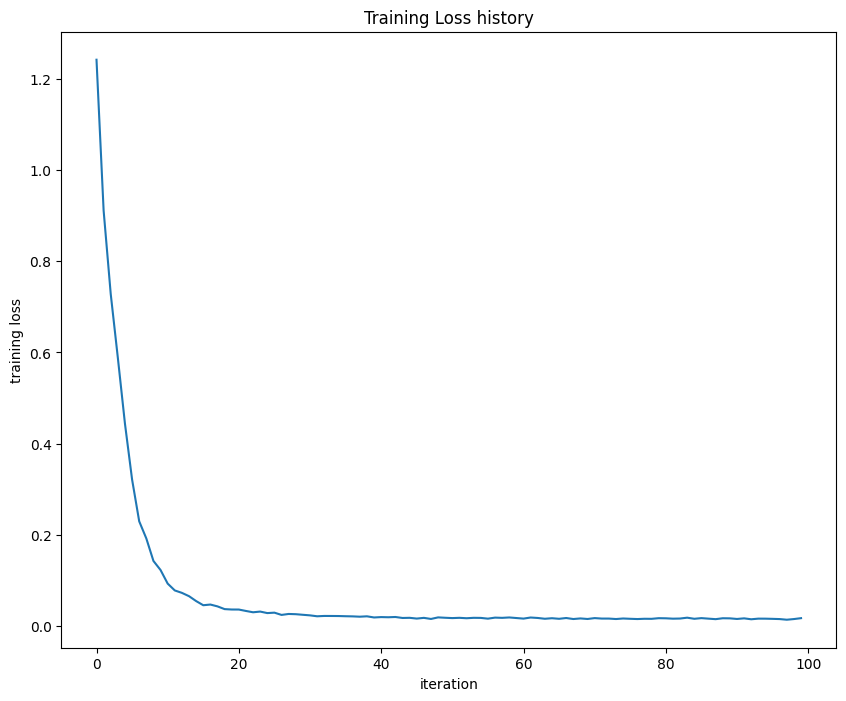

In [25]:
net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=5e-6,
            num_iters=100, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])

plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

# Обучение нейронной сети на реальном наборе данных (CIFAR-10, MNIST)

Загрузите набор данных, соответствующий вашему варианту. 

Разделите данные на обучающую, тестовую и валидационную выборки.

Выполните предобработку данных, как в ЛР 1. 

Обучите нейронную сеть на ваших данных. 

При сдаче лабораторной работы объясните значения всех параметров метода train.

In [39]:
cifar10_dir = 'scripts/datasets/cifar-10-batches-py'

try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Training data shape:  (45000, 32, 32, 3)
Training labels shape:  (45000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [40]:
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

X_train_flat = X_train.reshape(len(X_train), -1)
X_test_flat = X_test.reshape(len(X_test), -1)

print("Размеры обучающей выборки:", X_train_flat.shape)
print("Размеры тестовой выборки:", X_test_flat.shape)

(5000, 3072) (500, 3072)
Размеры обучающей выборки: (5000, 3072)
Размеры тестовой выборки: (500, 3072)


In [43]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

stats = net.train(X_train_flat, y_train, X_val_flat, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

val_acc = (net.predict(X_val_flat) == y_val).mean()
print('Validation accuracy: ', val_acc)

итерация 0 / 1000: потери 2.303003
итерация 100 / 1000: потери 2.301066
итерация 200 / 1000: потери 2.290571
итерация 300 / 1000: потери 2.238338
итерация 400 / 1000: потери 2.169096
итерация 500 / 1000: потери 2.131658
итерация 600 / 1000: потери 2.102310
итерация 700 / 1000: потери 2.109768
итерация 800 / 1000: потери 2.069146
итерация 900 / 1000: потери 2.073042
Validation accuracy:  0.2116


Используя параметры по умолчанию, вы можете получить accuracy, примерно равный 0.29. 

Проведите настройку гиперпараметров для увеличения accuracy. Поэкспериментируйте со значениями гиперпараметров, например, с количеством скрытых слоев, количеством эпох, скорости обучения и др. Ваша цель - максимально увеличить accuracy полносвязной сети на валидационном наборе. Различные эксперименты приветствуются. Например, вы можете использовать методы для сокращения размерности признакового пространства (например, PCA), добавить dropout слои и др. 

Для лучшей модели вычислите acсuracy на тестовом наборе. 

Для отладки процесса обучения часто помогают графики изменения loss и accuracy в процессе обучения. Ниже приведен код построения таких графиков. 

In [46]:
hidden_sizes = [125]
learning_rates = [0.001]
regularization_strengths = [0.75]
learning_rate_decays = [0.95]
num_iterss = [1500]
batch_sizes = [200]

best_val_accuracy = -1
best_test_accuracy = -1
best_hyperparams = {}

df = pd.DataFrame(columns=['hs', 'lr', 'rs', 'lrd', 'ni', 'bs', 'acc'])

for hs, lr, reg, lrd, ni, bs in itertools.product(hidden_sizes, learning_rates, regularization_strengths, learning_rate_decays, num_iterss, batch_sizes):
    net = TwoLayerNet(input_size, hs, num_classes)
    stats = net.train(X_train_flat, y_train, X_val_flat, y_val,
                      num_iters=ni, batch_size=bs,
                      learning_rate=lr, learning_rate_decay=lrd,
                      reg=reg, verbose=False)

    val_accuracy = (net.predict(X_val_flat) == y_val).mean()
    test_accuracy = (net.predict(X_test) == y_test).mean()
    params = {'hs': hs, 'lr': lr, 'rs': reg, 'lrd': lrd, 'ni': ni, 'bs': bs, 'acc': val_accuracy}

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_test_accuracy = test_accuracy
        best_hyperparams = params

    df = pd.concat([df, pd.DataFrame(params, index=[0])], ignore_index=True)

print("Лучшая точность на валидации:", best_val_accuracy)
print("Точность тестирования лучшей модели:", best_test_accuracy)
print("Лучшие гиперпараметры:", best_hyperparams)

print(df)

Лучшая точность на валидации: 0.366
Точность тестирования лучшей модели: 0.35
Лучшие гиперпараметры: {'hs': 125, 'lr': 0.001, 'rs': 0.75, 'lrd': 0.95, 'ni': 1500, 'bs': 200, 'acc': 0.366}
    hs     lr    rs   lrd    ni   bs    acc
0  125  0.001  0.75  0.95  1500  200  0.366


/tmp/ipykernel_18833/3074078082.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(params, index=[0])], ignore_index=True)


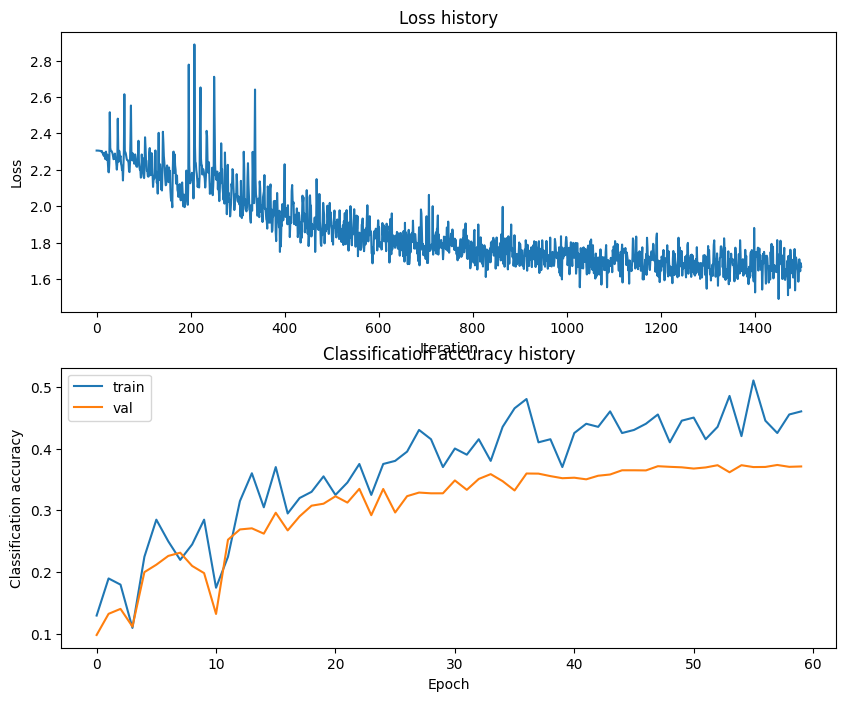

In [47]:
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

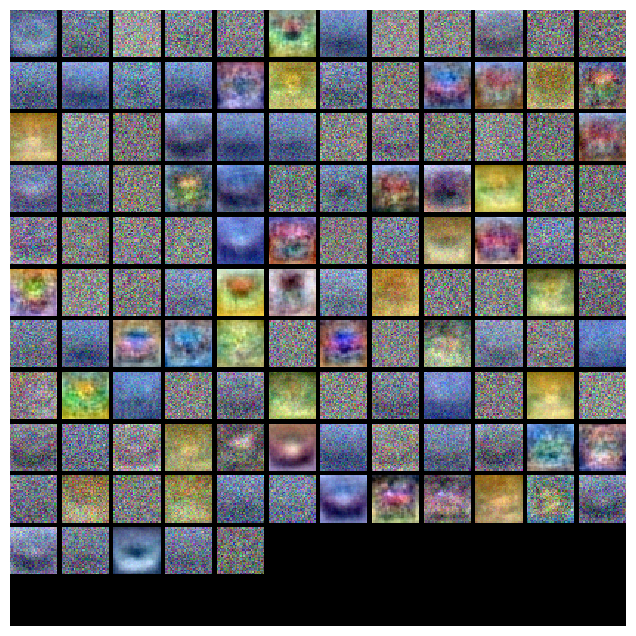

In [48]:
from scripts.vis_utils import visualize_grid

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(net)

Сделайте выводы по результатам работы. 

В результате настройки гиперпараметров для нейронной сети на датасете CIFAR-10 были получены следующие результаты:

Лучшая точность на валидационной выборке составила 36.6%.
Точность на тестовой выборке для лучшей модели равна 35%.
Для настройки гиперпараметров были перебраны следующие значения:

Размер скрытого слоя: 125.  
Скорость обучения: 0.001.   
Коэффициент регуляризации: 0.75.    
Скорость обучения decay: 0.95.  
Количество итераций: 1500.  
Размер пакета: 200. 